# DSM150 - Neural Networks Coursework 2

## Introduction

Introduced to the major public ChatGPT quickly demonstrated the enormous potential of Large Language Models(LLMs). This marked the beginning of a new era where the concepts of neural networks left academic circles, becoming a topic of conversations of everyday life. Subsequently, these LLMs introduced the capability of image recognition. Users are able to upload images and let them be analyzed and described by LLMs, which further underlined the versatility and potential of neural networks. Today, Convolutional Neural Networks have found extensive application across various fields. From medical imaging, such as fraction detection in x-ray images, to the 'simple' object detection on smartphones. The impact of CNNs is both profound and pervasive. This coursework report seeks to explore the practical realization of CNNs, as presented in "Deep Learning with Python", highlighting the indispensable role in the digital age. 


### Classification Task Overview

Following to the introduction, this section aims to define the specific classification task that forms the core focus of the coursework. The objective is to develop an CNN model capable to accurately classify images of animals into five distinct category, each representing a different type of animal. The animals for the classification tasks are as follows:
- Category 1: Cat
- Category 2: Dog
- Category 3: Elephant
- Category 4: Horse
- Category 5: Lion

The task is designed ti challenge the models ability to discem and learn from the unique feature characteristics of each animal type, ranging from texture and shape to size and environmental context. 





## Dataset Description

The dataset that is used for the classification task holds images representing five distinct animal categories ( also see 'Classification Task Overview'). These datset was sourced from Kaggle and can be found under the name 'Animals - Animals Classification Dataset [1]'. It contains 15'000 pictures of animals, which has been collected from Google Images. The Dataset is splitted in training images and validation images. The validation sets holds 300 images for each animal type. This roughly represents the relative size of 11% of the training images.

## Course Work Approach

This course work adopts a structured, iterative approach to explore, implement and refine Convolutional Neural Networks (CNNs) for an image recognitions task. The approach can be subdivided into distinct phases, each designed to build-up on the previous steps.  The process is as follows:

1. Exploring the Images:
- Show Images: A subset of the dataset will be visually examined to understand the variety and characteristics of the data. This step is designed to create an understanding of potential challenges in image recognition tasks, such as image orientation and lighting.
- Count of Images -> Class Distribution: This step is designed to picture the class distribution of target classes. This step is supposed to detect any class imbalances. A balanced dataset is essential to create a robust and unbiased model.

2. Loading and Preparation:
- This phase covers the image loading and preparation for the model training. This tasks covers preprocessing steps like image normalizing and rescaling the data, implementing an image generator and applying data augmentation techniques.

3. Define a Base Model:
- A baseline CNN is created and trained on the dataset prepared on the previous step. The model is supposed to serve as a reference in terms of performance and accuracy to identify areas of improvement.

4. Evaluate Base Model:
- Print Standard Parameters: Commonly parameters will be plotted such as trainings and validation accuracy in relation to observe the different training stages of the model. 
- Print Confusion Matrix: The performance of the baseline model will be evaluated by creating a confusion matrix, which gives insights to the models accuracy, recall and precision.

5. Structured Approach to improve Base Model:
- A systematic approach will be employed to  iteratively improve the base model. This involves changes in the architectures.

6. Using a Pretraine Convolutional Network:
- To further discover different techniques, a pretrained CNN will be incorporated. This approach will a allow the model to benefit from features learned on  vast amount of pictures and objects, aiming to improve the generalization capabilities. 

7. Visualizing Structures:
- Finally, the internal structures and features learned by the CNN will be visualized. This step is crucial for understanding how the model interprets and processes image data, providing valuable insights into its decision-making process.

## 1. Exploring the Images:

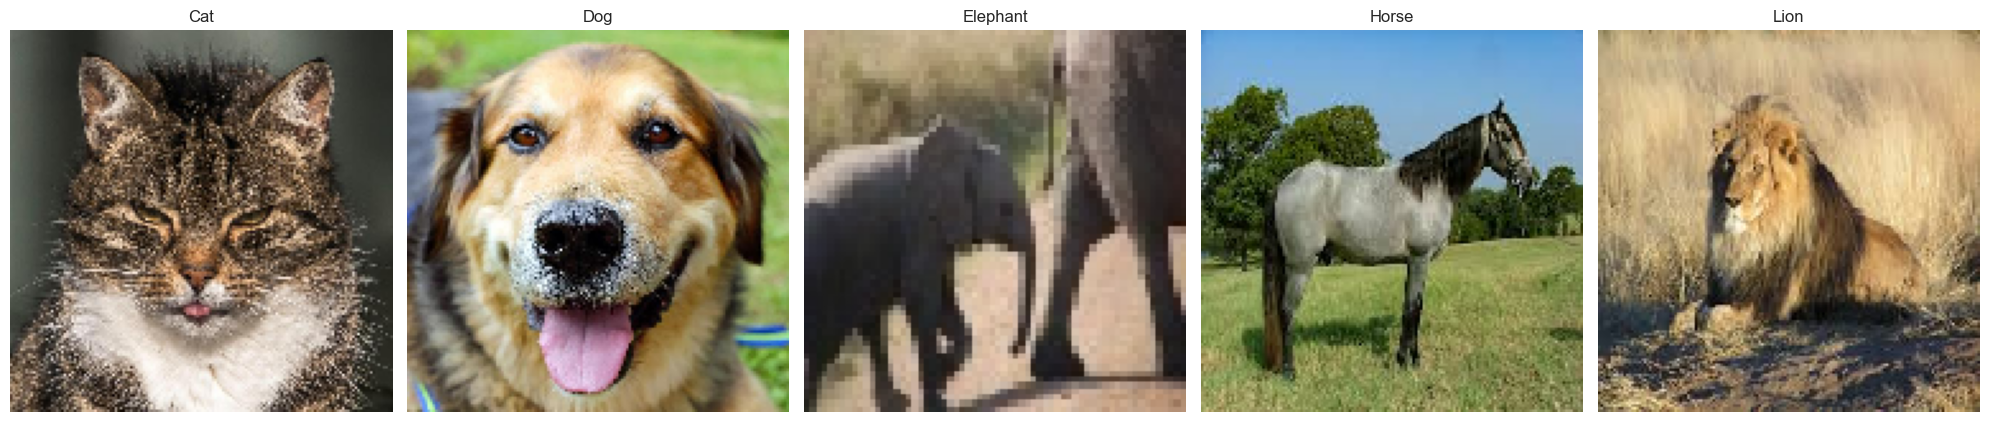

In [119]:
import os, random

import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt

dir_base_train= './data/animals/train/'
dir_train_cat= os.path.join(dir_base_train,'cat')
dir_train_dog= os.path.join(dir_base_train,'dog')
dir_train_elephant= os.path.join(dir_base_train,'elephant')
dir_train_horse= os.path.join(dir_base_train,'horse')
dir_train_lion= os.path.join(dir_base_train,'lion')

cat_path_img= os.path.join(dir_train_cat, random.choice(os.listdir(dir_train_cat)))
dog_path_img= os.path.join(dir_train_dog,random.choice(os.listdir(dir_train_dog)))
elephant_path_img= os.path.join(dir_train_elephant,random.choice(os.listdir(dir_train_elephant)))
horse_path_img= os.path.join(dir_train_horse, random.choice(os.listdir(dir_train_horse)))
lion_path_img= os.path.join(dir_train_lion, random.choice(os.listdir(dir_train_lion)))

cat_img = image.img_to_array(image.load_img(cat_path_img, target_size=(150,150)))
dog_img = image.img_to_array(image.load_img(dog_path_img, target_size=(150,150)))
elephant_img = image.img_to_array(image.load_img(elephant_path_img, target_size=(150,150)))
horse_img = image.img_to_array(image.load_img(horse_path_img, target_size=(150,150)))
lion_img = image.img_to_array(image.load_img(lion_path_img, target_size=(150,150)))

# Set up the matplotlib figure and axes, specifying the figure size and the grid layout
fig, axes = plt.subplots(1, 5, figsize=(20, 10))

# List of the images
images = [cat_img, dog_img, elephant_img, horse_img, lion_img]

# Titles for each subplot
titles = ['Cat', 'Dog', 'Elephant', 'Horse', 'Lion']

# Plot each image
for i, ax in enumerate(axes.flat):
    # Display image
    ax.imshow(images[i] / 255.)  # Normalize the image to [0,1] since matplotlib expects floats in [0,1] or integers in [0, 255]
    ax.set_title(titles[i])  # Set a title for each subplot
    ax.axis('off')  # Turn off axis

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()  # Display the figure with the images


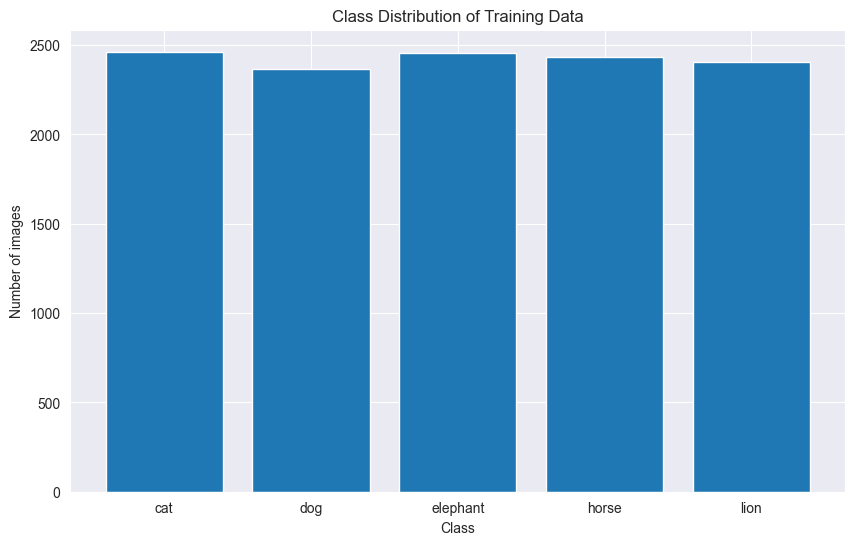

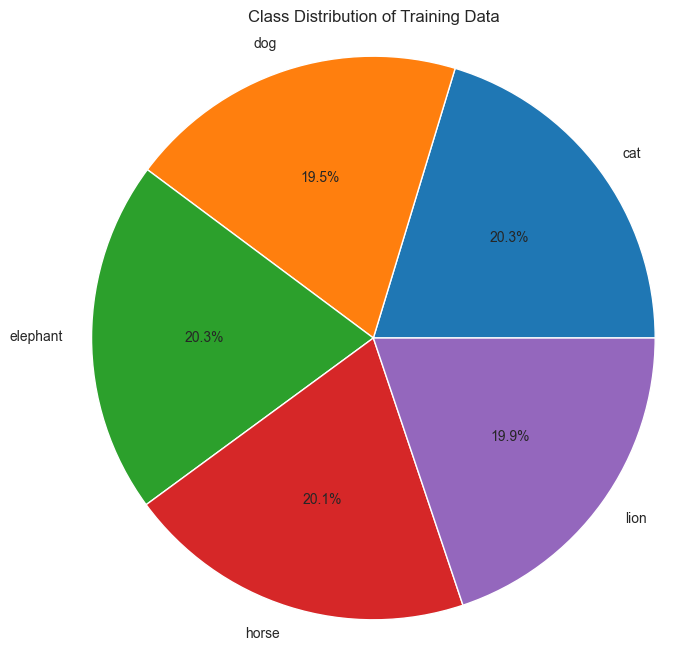

In [120]:
# Class distributions Images
classes = ['cat', 'dog', 'elephant', 'horse', 'lion']
class_counts = {}

for class_name in classes:
    dir_path = os.path.join(dir_base_train, class_name)
    class_counts[class_name] = len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])

# Data
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(classes, counts)
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Class Distribution of Training Data')
plt.show()

# Create pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=classes, autopct='%1.1f%%')
plt.title('Class Distribution of Training Data')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

On the above charts can be seen, that the data is almost equally distributed. Only minor differences can be stopped between each class. As a result there is not need to take care of under- or overrepresented classes in the process of data preparation. There is no risk of a bias caused by an imbalanced dataset.

# 2. Loading and Preparation

The used dateset was downloaded from Kaggel. The dataset originally consists of a 'train' and 'val' folder. Both folders will be used training the model. To generate an unbiased measure of the models performance a test set will be created an hold back to evaluated the model with unseen data.

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers

In [24]:
# define base directory where pictures stored
dir_base_train= './data/animals/train/'
dir_base_val= './data/animals/val/'
dir_base_test= './data/animals/test/'

In [25]:
import os, shutil
from sklearn.model_selection import train_test_split

animal_classes= ['cat', 'dog', 'elephant','horse', 'lion'] 


# define relative size testset
test_size= 0.1

# define a directory for each class

for class_dir in animal_classes:
    
    dest_dir= os.path.join(dir_base_test, class_dir)
    
    # define the source directory
    src_dir= os.path.join(dir_base_train, class_dir)
    
    # get all the files names from the dir
    fnames= os.listdir(src_dir)
    
    train_files, test_files = train_test_split(fnames, test_size=test_size, random_state= 42)
    
    # define destination dir
    os.makedirs(dest_dir, exist_ok=True)
    
    # move files to test dir
    for fname in test_files:
        shutil.move(os.path.join(dir_base_train, class_dir, fname), os.path.join(dest_dir, fname))

In [4]:
# import lib for Image Generator
#from keras.preprocessing.image import ImageDataGenerator

# rescale images by 1/255
train_datagen= ImageDataGenerator(rescale=1./255)
val_datagen= ImageDataGenerator(rescale=1./255)
test_datagen= ImageDataGenerator(rescale=1./255)

In [5]:

# read img from target dirs, resize image to 150x150, 
train_generator= train_datagen.flow_from_directory(
    dir_base_train,
    target_size=(150,150),
    batch_size=64,
    class_mode='categorical',
    shuffle= True
    
)


Found 10910 images belonging to 5 classes.


In [6]:
val_generator= val_datagen.flow_from_directory(
    dir_base_val,
    target_size=(150,150),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

Found 1497 images belonging to 5 classes.


In [50]:
# define generator fo test data
test_generator= test_datagen.flow_from_directory(
    dir_base_test,
    target_size= (150,150),
    batch_size= 64,
    class_mode= 'categorical',
    shuffle= False
)

Found 1349 images belonging to 5 classes.


In [8]:
for data_batch, labels_batch in train_generator:
    print('Data batch shape:', data_batch.shape)
    print('Labels batch shape:', labels_batch.shape)
    break

Data batch shape: (64, 150, 150, 3)
Labels batch shape: (64, 5)


In [9]:
input_shape= (150, 150, 3)

### Helper Functions:

Three helper functions are shown in the following sections. The functions are always used to illustrate the performance of a model. Combining and separating this functionality makes it possible to make the code more modular and clearer. The functions can be summarized as follows:

- plot_acc_loss: These functions plots the training history of the model for accuracy and loss including the accuracy and loss of the validation data.
- plot_roc_auc: Here the ROC-AUC curve is broken down into the individual classes in order to see the classification performance of the model.
- plot_classification_report: This method uses the confusion matrix to print the classification report to get the precision, recall and F1 score values.
- plot_conf_matrix: Using this method, a heatmap is plotted that depicts the confusion matrix for the individual target classes.

In [121]:
import matplotlib.pyplot as plt

def plot_acc_loss(history):
    # Extracts trainings metrics from the training history
    acc = history.history['accuracy']  # Training accuracy for each epoch
    val_acc = history.history['val_accuracy']  # Validation accuracy for each epoch
    loss = history.history['loss']  # Training loss for each epoch
    val_loss = history.history['val_loss']  # Validation loss for each epoch

    # Generates a list of epoch numbers starting from 1 to the number of the final epoch
    epochs = range(1, len(acc) + 1)

    # Plotting the Training Accuracy
    plt.plot(epochs, acc, 'bo', label='Training acc')  # 'bo' for blue dot
    plt.plot(epochs, val_acc, 'b', label='Validation acc')  # 'b' for a solid blue line
    plt.title('Training and validation accuracy')  # Title of the first plot
    plt.legend()  # Displays a legend to label the training and validation accuracy

    plt.figure()  # Creates a new figure for the next plot

    # Plotting the Training Loss
    plt.plot(epochs, loss, 'bo', label='Training loss')  # Again, 'bo' for blue dot
    plt.plot(epochs, val_loss, 'b', label='Validation loss')  # And 'b' for a solid blue line
    plt.title('Training and validation loss')  # Title of the second plot
    plt.legend()  # Displays a legend to label the training and validation loss

    plt.show()  # Displays the plots

The function *plot_acc_loss takes* a history object from a trained model and visualizes its training and validation accuracy, as well as loss over all epochs. It generates two plots: the first shows the accuracy of the model during training and validation, and the second shows the loss during training and validation. This function is useful for evaluating the model's performance over time, checking for overfitting, and making decisions about further training and model adjustments.

In [11]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt  # Import matplotlib for plotting

def plot_roc_auc(model, test_generator):
    # Calculate the number of steps per epoch for the test set
    # Use ceil to ensure that no sample is missed
    test_steps = np.ceil(test_generator.samples / test_generator.batch_size).astype(int)
    
    # Use the model to predict probabilities for each class on the test set
    prediction_probabilities = model.predict(test_generator, steps=test_steps)
    
    # Get the true labels from the generator
    true_labels = test_generator.classes
    
    # Convert true labels to one-hot encoded format for ROC AUC computation
    true_labels = to_categorical(true_labels, num_classes=5)
    
    # Dictionary to store ROC AUC values
    roc_auc_dict = {}
    
    # Calculate ROC AUC for each class
    for i in range(5):  # Loop through each class
        # Compute False Positive Rate (fpr), True Positive Rate (tpr), and threshold values for ROC
        fpr, tpr, thresholds = roc_curve(true_labels[:, i], prediction_probabilities[:, i])
        # Calculate the AUC (Area Under Curve) for the current class
        roc_auc = auc(fpr, tpr)
        # Store the AUC in the dictionary with class index as key
        roc_auc_dict[f'(i)'] = roc_auc
        # Plot the ROC curve for the current class
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (area = {roc_auc})')
        
    # Plot the ROC curves
    # Add a diagonal dashed line that represents random chance
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    # Set the limits for the x-axis
    plt.xlim([0.0, 1.0])
    # Set the limits for the y-axis
    plt.ylim([0.0, 1.05])
    # Label the x-axis as 'False Positive Rate'
    plt.xlabel('False Positive Rate')
    # Label the y-axis as 'True Positive Rate'
    plt.ylabel('True Positive Rate')
    # Set the title of the plot
    plt.title('Receiver Operating Characteristic for multi-class')
    # Show the legend at the lower right corner of the plot
    plt.legend(loc="lower right")
    # Display the plot
    plt.show()
    
    # Calculate and print the overall ROC AUC score using a One-vs-One comparison strategy
    overall_roc_auc_score = roc_auc_score(true_labels, prediction_probabilities, multi_class='ovo')
    print('Overall ROC AUC:', overall_roc_auc_score)


The function *plot_roc_auc* takes a model and a ImageGenerator object. It extracts the true labels from the ImageGenerator and predicts the pictures from the ImageGenerator. Based on the predictions and true labels the false positive rate, true positive rate and thresholds are calculated. Following the receiver operating characteristic and area under the curve are calculated. The values are stored in a dict and the ROC-AUC curve is plotted.

The scale and labels for the plot are then set. Finally, the plot is displayed together with the overall ROC AUC value.


In [71]:
from sklearn.metrics import classification_report

def print_classification_report(true_labels, predicted_classes, class_labels):
    # Generate a classification report by comparing the true and predicted classes
    # The report includes key metrics such as precision, recall, f1-score for each class
    report = classification_report(true_labels, predicted_classes, target_names=class_labels)

    # Print the classification report to the console
    print(report)


The function *print_classification_report* prints  a classification report for a trained model based on the test images. It takes the 'true labels' of the target images and the corresponding predicted classes. Based on this input a classification report is generated and printed to show accuracy, recall, precision and F1-Score for the model.

In [72]:
import numpy
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt  # Importing the plotting library

# Function to plot the confusion matrix for the predictions from a model
def plot_conf_matrix(model, test_generator):
    
    # Predict the outputs for the test_generator samples using the provided model
    predictions = model.predict(
        test_generator,
        steps= test_generator.samples / test_generator.batch_size  # Ensure all samples are used
    )
    # Convert the probabilities into class labels by taking the argmax (index of highest probability)
    predicted_labels = numpy.argmax(predictions, axis=1)
    
    # Get the true class labels from the generator
    true_labels = test_generator.classes
    # Get the class label names from the generator for labeling the confusion matrix
    class_labels = list(test_generator.class_indices.keys())
    
    # Generate the confusion matrix comparing true and predicted class labels
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
        
    # Set up the matplotlib figure with  size 10 x 7
    plt.figure(figsize=(10, 7))
    # Use seaborn to create a heatmap visualization of the confusion matrix
    sns.heatmap(
        conf_matrix, 
        annot=True,  # Annotate the heatmap with the actual number of observations
        fmt='g',  # Use general format for annotations
        cmap='Blues',  # Use a blue color map for the heatmap
        xticklabels=class_labels,  # Set the x-axis labels to the class label names
        yticklabels=class_labels  # Set the y-axis labels to the class label names
    )
    # Label the x-axis as 'Predicted'
    plt.xlabel('Predicted')
    # Label the y-axis as 'True'
    plt.ylabel('True')
    # Display the plot
    plt.show()
    
    # Call the function to print the classification report
    print_classification_report(true_labels, predicted_labels, class_labels)


The function *plot_conf_matrix* receives a model and ImageDataGenerator object to create and plot a confusion  matrix. First, the ImageDataGenerator is used to extract the true labels of the data. Following, the model predicts the labels of the test data. Based on the true and predicted labels a confusion matrix is created. Afterwards the condfusion matrix is plotted using a seaborn heatmap.

Finally the function *print_classification_report* is called to print the corresponding classification report.

## 3. Define a Base Model

In the following section a base model is defined. The base model should serve as a reference point building a more precise model. The aim is to keep the base model as simple as possible and achieving a statistical signiificanc 


In [212]:
# intializing base model
base_model= models.Sequential()
base_model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape= input_shape))
base_model.add(layers.MaxPooling2D((2,2)))
base_model.add(layers.Conv2D(32, (3,3), activation= 'relu'))
base_model.add(layers.MaxPooling2D((2,2)))
base_model.add(layers.Conv2D(64, (3,3), activation= 'relu'))
base_model.add(layers.MaxPooling2D((2,2)))
base_model.add(layers.Flatten())
base_model.add(layers.Dense(32, activation='relu'))
base_model.add(layers.Dense(5, activation='softmax'))

In [213]:
base_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 74, 74, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 36, 36, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 17, 17, 64)      

In [214]:
base_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [215]:
steps_per_epoch= train_generator.samples // train_generator.batch_size
validation_steps= val_generator.samples // val_generator.batch_size

In [216]:
train_generator.samples // train_generator.batch_size

189

In [217]:
base_history= base_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs= 10,
    validation_data= val_generator,
    validation_steps= validation_steps
)

Epoch 1/10
189/189 [==============================] - 26s 135ms/step - loss: 1.0534 - accuracy: 0.5757 - val_loss: 0.7119 - val_accuracy: 0.7174
Epoch 2/10
189/189 [==============================] - 26s 135ms/step - loss: 0.6170 - accuracy: 0.7610 - val_loss: 0.5306 - val_accuracy: 0.8064
Epoch 3/10
189/189 [==============================] - 26s 135ms/step - loss: 0.4945 - accuracy: 0.8095 - val_loss: 0.5264 - val_accuracy: 0.7826
Epoch 4/10
189/189 [==============================] - 26s 135ms/step - loss: 0.4089 - accuracy: 0.8440 - val_loss: 0.4356 - val_accuracy: 0.8329
Epoch 5/10
189/189 [==============================] - 26s 135ms/step - loss: 0.3517 - accuracy: 0.8646 - val_loss: 0.4533 - val_accuracy: 0.8207
Epoch 6/10
189/189 [==============================] - 26s 136ms/step - loss: 0.2953 - accuracy: 0.8872 - val_loss: 0.3903 - val_accuracy: 0.8560
Epoch 7/10
189/189 [==============================] - 26s 135ms/step - loss: 0.2557 - accuracy: 0.9041 - val_loss: 0.4299 - val_ac

## 4. Evaluate Base Model

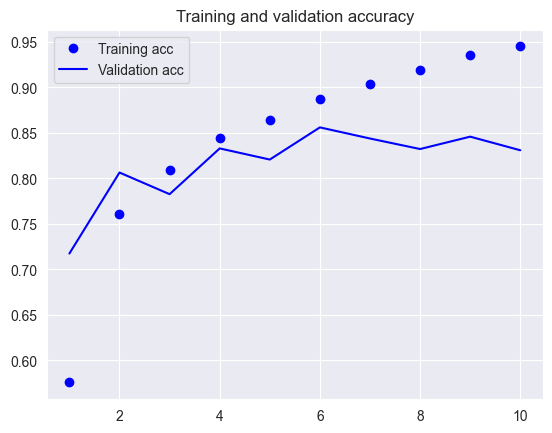

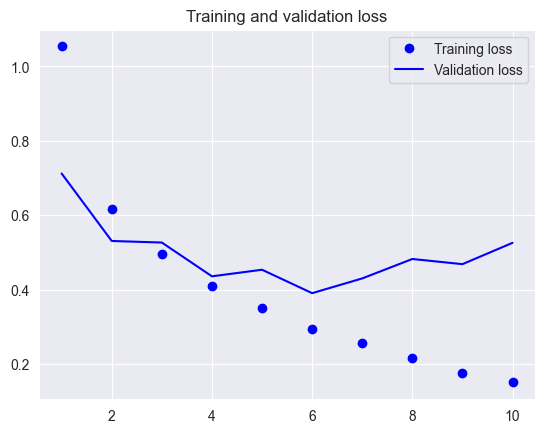

In [218]:
plot_acc_loss(base_history)

In general the base model achieve an accuracy of 0.94%. Based in the plot off accuracies and losses the model shows an absolutely justifiable perfomance. Nevertheless the model starts showing typicall signs of overfitting from epoch 6 onwards. The trainings accuracy is increasing and the validation accuracy is not following and stagnates a around 83% accuracy. The same pattern can be observed for the training and validation loss. The trainings loss is decreasing for each epoch. Whereas the validation loss increases from the 6th epoch onwards.

In the next step I will evaluate the model using the test data. To do this, the model will need to classify unseen images. Based on the predictions and the actual values, the performance of the model can be assessed more accurately.

In [51]:
# predicting unseen data and printing the ROCH => See helper functions for details of method plot_roc_auc
plot_roc_auc(base_model, test_generator)

NameError: name 'base_model' is not defined

The Receiver Operating Characteritsic (ROC) graph shows the models performance for classifying each class. Overall all the individual classes show high AUC values with minor differences between the single classes. That means the model has a high true positiv rate (TPR). The overall AUC ROC value with roughly 96% represents an aggregate measure of all the classes. The high value indicates a high discrimination capability for the model between the target classes. In addition to the high values, it can also be seen that the TOR for classes 3, 4 and 5 are lower. This means that the model can, for example, distinguish between classes 1 and 2 (cat and dog) very well. The model performs worse in the other classes. The model performs worst, especially in class 3, the Elephant class.

A confusion matrix could provide more insights here. Additionaly the values for Accuracy, Precision and Recall are printed to give more detailes insights for the classes.



21/21 [==============================] - 2s 99ms/step


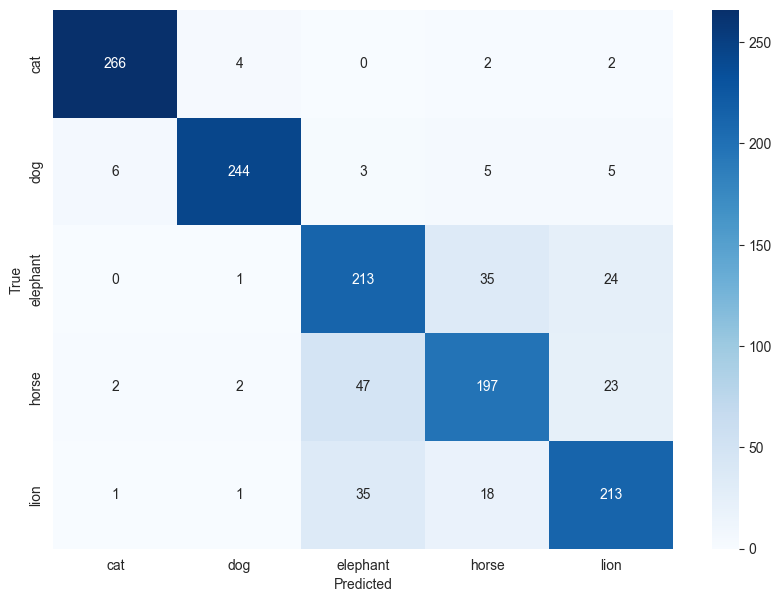

              precision    recall  f1-score   support

         cat       0.97      0.97      0.97       274
         dog       0.97      0.93      0.95       263
    elephant       0.71      0.78      0.75       273
       horse       0.77      0.73      0.75       271
        lion       0.80      0.79      0.80       268

    accuracy                           0.84      1349
   macro avg       0.84      0.84      0.84      1349
weighted avg       0.84      0.84      0.84      1349


In [211]:
plot_conf_matrix(base_model, test_generator)

Observations in the confusion matrix:

- Cats and Dogs (class 0 and 1): The model perform exceptional well on cats and dogs. There high number of true positives and a low number of misclassifications
- Elephants (class 2): The model struggles to classify elephants correctly. Elephants were misclassified as horses or lions
- Horses (class 3): There also notable misclassifications for horses 
- Lions (class 4): Lions are sometimes misclassified as horses or elephants, but still have a high true positiv count

It seems to be that the model has difficulties to distinguish between horses and elephants.

Observations Classification Report:

- Cats and Dogs: High precision and recall, indicating very view misclassifications
- Elephnats: This class has the lowest precision and a low recall, showing that not all elephants have been correctly classified as elephants and that they were more often misclassified as other animals (especially horeses and lions)
- Horses: The precision and recall shows also relatively low values

Still the overall accuracy of the base model is still high, even if this metric is not reflecting the class specific performance. The wighted average and the macro average showing the same values which is an indicator, that the dataset is well balanced for all 5 classes.

To improve the models performance, especially the ability to better discrimate between classes like horses and elephant, following steps will be applied:
- reduce complexity of model architecture
- add drop-out layers to improve generalization
- reduce the number of filters for the Conv2D-layers
- add regualizers


For the next step the achritecture of the model is simplidied. It has less Conv2D layers, viewer filters and reduced number of neurons for the dense layer.

In [219]:
# intializing simpler  model
simple_model= models.Sequential()
simple_model.add(layers.Conv2D(8, (3,3), activation='relu', input_shape= input_shape))
simple_model.add(layers.MaxPooling2D((2,2)))
simple_model.add(layers.Conv2D(16, (3,3), activation= 'relu'))
simple_model.add(layers.MaxPooling2D((2,2)))
simple_model.add(layers.Flatten())
simple_model.add(layers.Dense(20, activation='relu'))
simple_model.add(layers.Dense(5, activation='softmax'))

In [220]:
simple_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [221]:
simple_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 148, 148, 8)       224       
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 74, 74, 8)         0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 72, 72, 16)        1168      
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 36, 36, 16)        0         
 ng2D)                                                           
                                                                 
 flatten_16 (Flatten)        (None, 20736)             0         
                                                                 
 dense_33 (Dense)            (None, 20)              

In [223]:
simple_history= simple_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs= 10,
    validation_data= val_generator,
    validation_steps= validation_steps
)

Epoch 1/10
189/189 [==============================] - 24s 127ms/step - loss: 0.3777 - accuracy: 0.8570 - val_loss: 0.5302 - val_accuracy: 0.7935
Epoch 2/10
189/189 [==============================] - 24s 126ms/step - loss: 0.3158 - accuracy: 0.8832 - val_loss: 0.5283 - val_accuracy: 0.7948
Epoch 3/10
189/189 [==============================] - 24s 127ms/step - loss: 0.2599 - accuracy: 0.9067 - val_loss: 0.5449 - val_accuracy: 0.7989
Epoch 4/10
189/189 [==============================] - 24s 127ms/step - loss: 0.2026 - accuracy: 0.9299 - val_loss: 0.5348 - val_accuracy: 0.7996
Epoch 5/10
189/189 [==============================] - 24s 127ms/step - loss: 0.1691 - accuracy: 0.9447 - val_loss: 0.5857 - val_accuracy: 0.8030
Epoch 6/10
189/189 [==============================] - 24s 127ms/step - loss: 0.1449 - accuracy: 0.9517 - val_loss: 0.5612 - val_accuracy: 0.8118
Epoch 7/10
189/189 [==============================] - 24s 127ms/step - loss: 0.1081 - accuracy: 0.9687 - val_loss: 0.6106 - val_ac

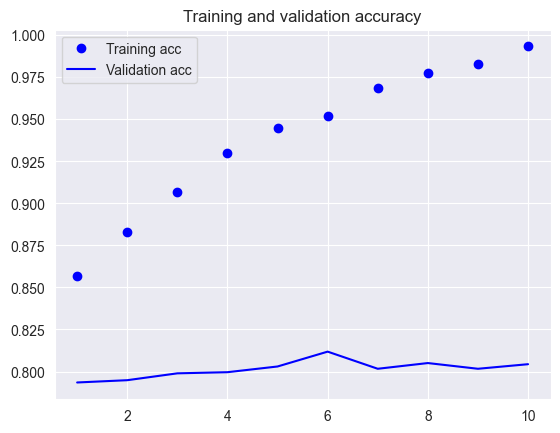

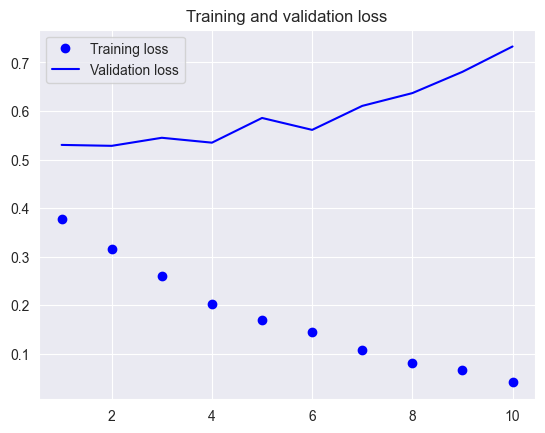

In [224]:
plot_acc_loss(simple_history)

The trainings accuracy of the model is high, meaning that the model can  adapt to the training data very well. The accuracy of the validation data compared to the training data is relatively low, though. This behavior indicates that the model is not good at generalizing on unseen data, which is a sign of overfitting. Also this behavior can be observed for the corresponding loss curve. The validation loss is not following the trainings loss downwards. 

22/22 [==============================] - 2s 96ms/step


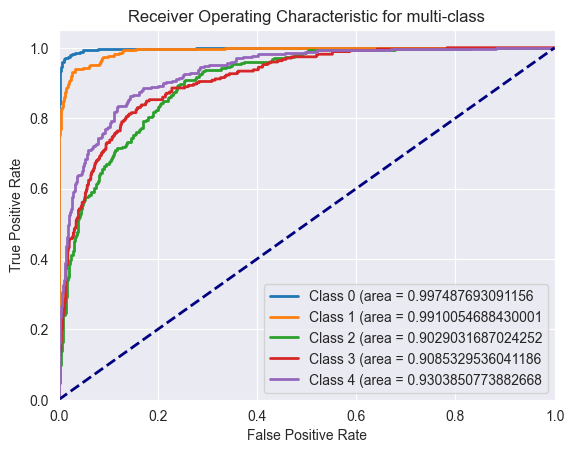

Overall ROC AUC: 0.9460628723257933


In [227]:
plot_roc_auc(simple_model, test_generator)

The ROC graphs shows a extraordinary performance for classifying cats and dogs. However, a clear deterioration can be seen in the elephant, horse and lion classes. This is also clear in the overall ROC AUC value, which has worsened by 2 percentage points compared to the previous model.

21/21 [==============================] - 2s 94ms/step


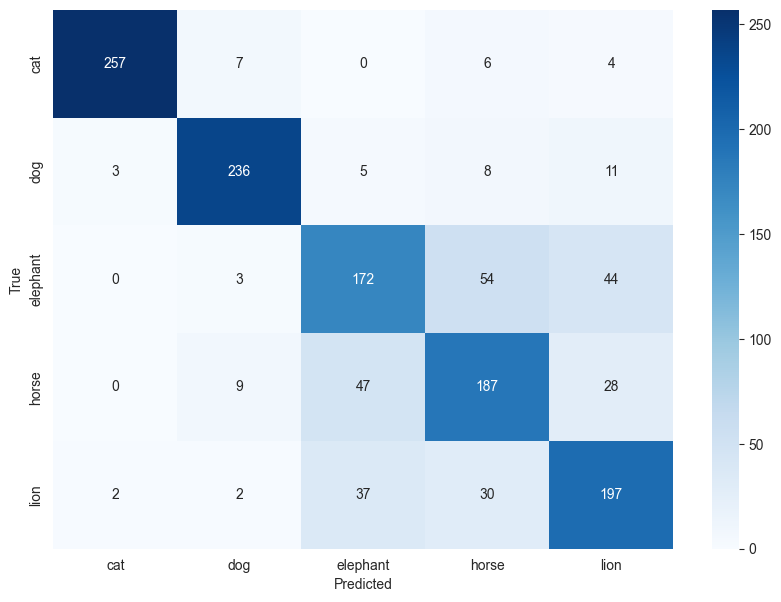

              precision    recall  f1-score   support

         cat       0.98      0.94      0.96       274
         dog       0.92      0.90      0.91       263
    elephant       0.66      0.63      0.64       273
       horse       0.66      0.69      0.67       271
        lion       0.69      0.74      0.71       268

    accuracy                           0.78      1349
   macro avg       0.78      0.78      0.78      1349
weighted avg       0.78      0.78      0.78      1349


In [228]:
plot_conf_matrix(simple_model, test_generator)

A deteriorated line is also clear in the confusion matrix. Here too, the correct classification of the classes elephant, horse and lion was much worse. The elephant and horse classes were most often incorrectly differentiated. This suggests that the model with the reduced architecture is unable to recognize the complex differences between elephants and horses.

This is also reflected in the classification report. The weighted average also catches the eye. This is 6 percent points worse than the basic model.

In order to improve the performance of the model, in the next steps I will increase the complexity of the architecture again, use data augmentation, as well as dropout layers and regularizers.

# Applying Data Augmentation

In [26]:
train_aug_img_data_gen= ImageDataGenerator(
    rescale= 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range= 0.2,
    shear_range=0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    fill_mode='nearest'
)

In [27]:
val_aug_img_data_gen= ImageDataGenerator(
    rescale= 1./255,
)

In [28]:
train_aug_generator= train_aug_img_data_gen.flow_from_directory(
    dir_base_train,
    target_size=(150,150),
    batch_size=64,
    class_mode='categorical',
    shuffle= True,
)

Found 12125 images belonging to 5 classes.


In [29]:
val_aug_generator= val_aug_img_data_gen.flow_from_directory(
    dir_base_val,
    target_size=(150,150),
    batch_size=64,
    class_mode='categorical',
    shuffle= True  
)

Found 1497 images belonging to 5 classes.


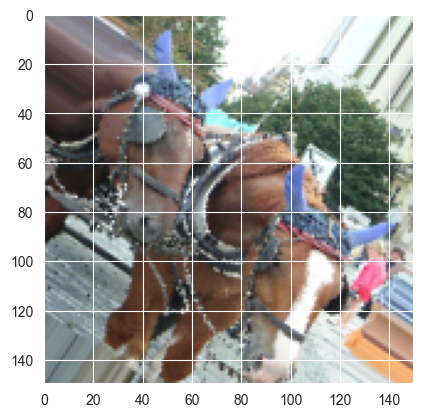

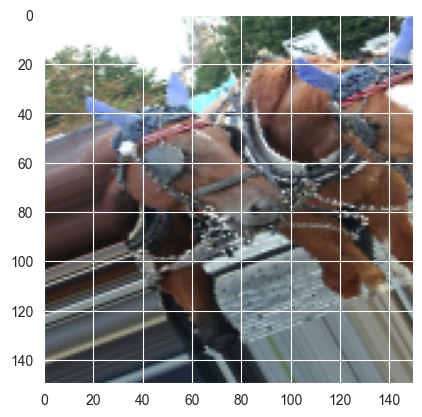

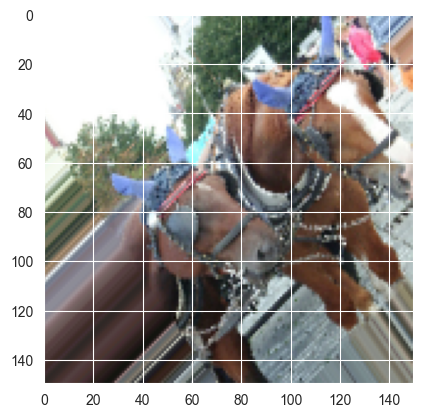

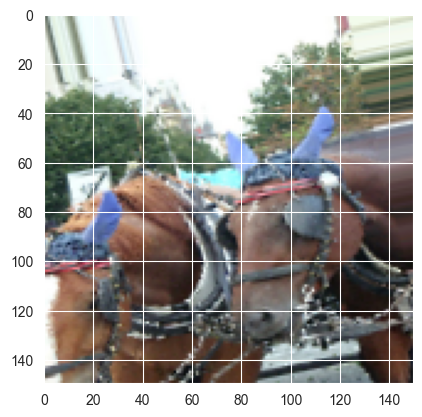

In [30]:
# displaying some random pics
from keras.preprocessing import image

fnames= [os.path.join('./data/animals/train/horse', fname) for fname in os.listdir('./data/animals/train/horse') ]

img_path= fnames[6]

img= image.load_img(img_path, target_size=(150,150))

x= image.img_to_array(img)
x= x.reshape((1,) + x.shape)

i=0

for batch in train_aug_img_data_gen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot= plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
    
plt.show()

In [89]:
from tensorflow.keras import regularizers

# intializing model
model_da= models.Sequential()
model_da.add(layers.Conv2D(32, (3,3), activation='relu', input_shape= input_shape, kernel_regularizer=regularizers.l2(1e-5)))
model_da.add(layers.MaxPooling2D((2,2)))
model_da.add(layers.Dropout(0.5))
model_da.add(layers.Conv2D(64, (3,3), activation= 'relu', kernel_regularizer=regularizers.l2(1e-5)))
model_da.add(layers.MaxPooling2D((2,2)))
model_da.add(layers.Dropout(0.5))
model_da.add(layers.Flatten())
model_da.add(layers.Dropout(0.5))
model_da.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-5)))
model_da.add(layers.Dense(5, activation='softmax'))

In [90]:
model_da.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model_da.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [91]:
steps_per_epoch= np.ceil(train_aug_generator.samples / train_aug_generator.batch_size)
validation_steps= np.ceil(val_aug_generator.samples / val_aug_generator.batch_size)

In [92]:
history_da= model_da.fit(
    train_aug_generator,
    steps_per_epoch=steps_per_epoch,
    epochs= 50,
    validation_data= val_aug_generator,
    validation_steps= validation_steps
)

Epoch 1/50
190/190 [==============================] - 55s 288ms/step - loss: 1.6486 - accuracy: 0.2923 - val_loss: 1.4661 - val_accuracy: 0.4395
Epoch 2/50
190/190 [==============================] - 53s 279ms/step - loss: 1.3890 - accuracy: 0.4219 - val_loss: 1.2520 - val_accuracy: 0.5364
Epoch 3/50
190/190 [==============================] - 52s 275ms/step - loss: 1.3007 - accuracy: 0.4692 - val_loss: 1.1368 - val_accuracy: 0.5524
Epoch 4/50
190/190 [==============================] - 52s 273ms/step - loss: 1.1838 - accuracy: 0.5276 - val_loss: 0.9695 - val_accuracy: 0.6319
Epoch 5/50
190/190 [==============================] - 52s 274ms/step - loss: 1.1185 - accuracy: 0.5556 - val_loss: 0.8973 - val_accuracy: 0.6379
Epoch 6/50
190/190 [==============================] - 52s 275ms/step - loss: 1.0687 - accuracy: 0.5801 - val_loss: 0.8940 - val_accuracy: 0.6473
Epoch 7/50
190/190 [==============================] - 52s 274ms/step - loss: 1.0320 - accuracy: 0.6000 - val_loss: 0.8005 - val_ac

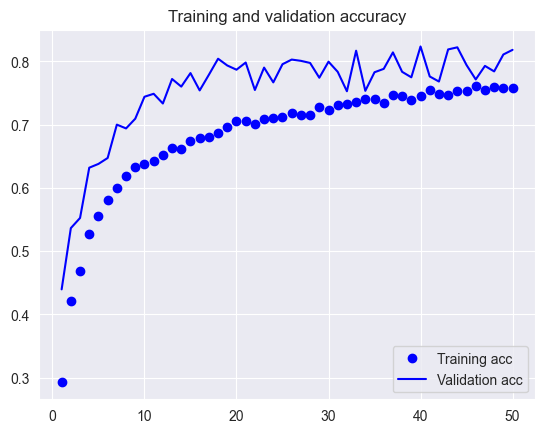

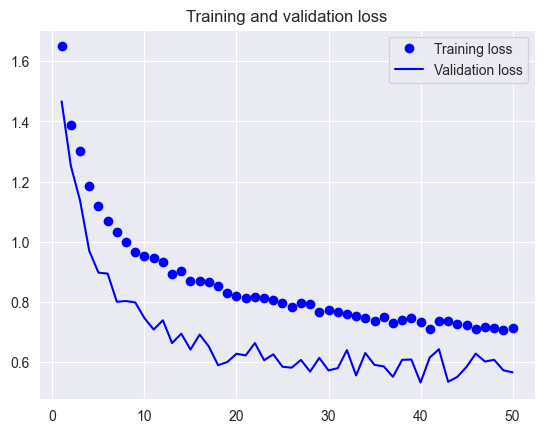

In [93]:
plot_acc_loss(history_da)

22/22 [==============================] - 2s 111ms/step


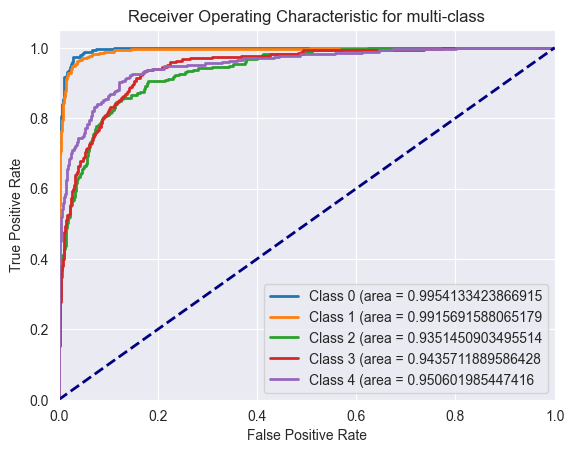

Overall ROC AUC: 0.963260153189764


In [94]:
plot_roc_auc(model_da, test_generator)

The model show improvements compared to the previous model. Following I will print the confusion matrix.

21/21 [==============================] - 2s 104ms/step


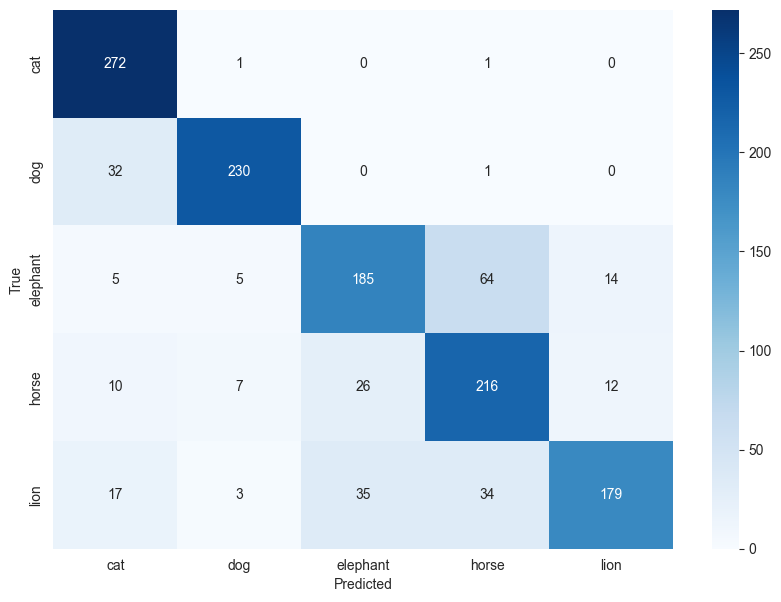

              precision    recall  f1-score   support

         cat       0.81      0.99      0.89       274
         dog       0.93      0.87      0.90       263
    elephant       0.75      0.68      0.71       273
       horse       0.68      0.80      0.74       271
        lion       0.87      0.67      0.76       268

    accuracy                           0.80      1349
   macro avg       0.81      0.80      0.80      1349
weighted avg       0.81      0.80      0.80      1349


In [95]:
plot_conf_matrix(model_da, test_generator)

In [97]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor= 'val_loss',
    patience=5,
    verbose= 1,
    restore_best_weights= True
) 

In [98]:
from tensorflow.keras import regularizers

# intializing model
model_da_es= models.Sequential()
model_da_es.add(layers.Conv2D(32, (3,3), activation='relu', input_shape= input_shape, kernel_regularizer=regularizers.l2(1e-5)))
model_da_es.add(layers.MaxPooling2D((2,2)))
model_da_es.add(layers.Dropout(0.5))
model_da_es.add(layers.Conv2D(64, (3,3), activation= 'relu', kernel_regularizer=regularizers.l2(1e-5)))
model_da_es.add(layers.MaxPooling2D((2,2)))
model_da_es.add(layers.Dropout(0.5))
model_da_es.add(layers.Flatten())
model_da_es.add(layers.Dropout(0.5))
model_da_es.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-5)))
model_da_es.add(layers.Dense(5, activation='softmax'))

In [99]:
model_da_es.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model_da.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [100]:
steps_per_epoch= np.ceil(train_aug_generator.samples / train_aug_generator.batch_size)
validation_steps= np.ceil(val_aug_generator.samples / val_aug_generator.batch_size)

In [102]:
history_da_es= model_da_es.fit(
    train_aug_generator,
    steps_per_epoch=steps_per_epoch,
    epochs= 60,
    validation_data= val_aug_generator,
    validation_steps= validation_steps,
    callbacks= [early_stopping]
)

Epoch 1/60
190/190 [==============================] - 53s 279ms/step - loss: 1.6788 - accuracy: 0.2803 - val_loss: 1.4748 - val_accuracy: 0.3641
Epoch 2/60
190/190 [==============================] - 54s 281ms/step - loss: 1.3942 - accuracy: 0.4081 - val_loss: 1.2132 - val_accuracy: 0.5057
Epoch 3/60
190/190 [==============================] - 53s 280ms/step - loss: 1.2599 - accuracy: 0.4890 - val_loss: 1.1653 - val_accuracy: 0.5331
Epoch 4/60
190/190 [==============================] - 53s 281ms/step - loss: 1.1702 - accuracy: 0.5298 - val_loss: 0.8884 - val_accuracy: 0.6460
Epoch 5/60
190/190 [==============================] - 54s 282ms/step - loss: 1.1084 - accuracy: 0.5637 - val_loss: 0.9967 - val_accuracy: 0.6219
Epoch 6/60
190/190 [==============================] - 55s 287ms/step - loss: 1.0665 - accuracy: 0.5835 - val_loss: 0.8591 - val_accuracy: 0.6854
Epoch 7/60
190/190 [==============================] - 54s 283ms/step - loss: 1.0277 - accuracy: 0.6016 - val_loss: 0.8053 - val_ac

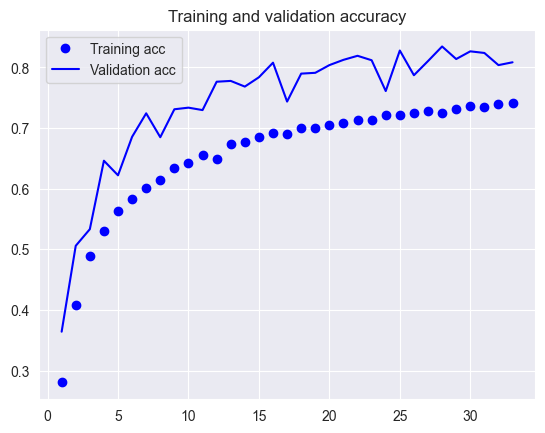

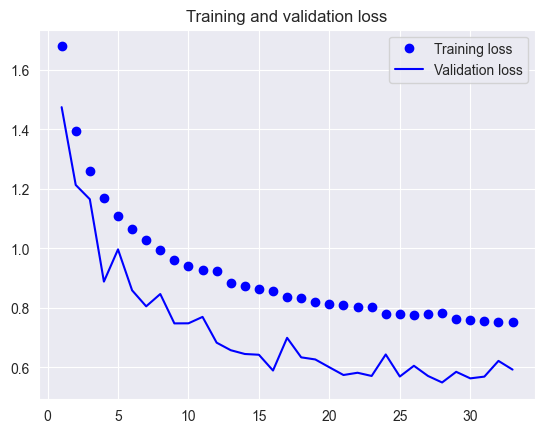

In [103]:
plot_acc_loss(history_da_es)

22/22 [==============================] - 3s 111ms/step


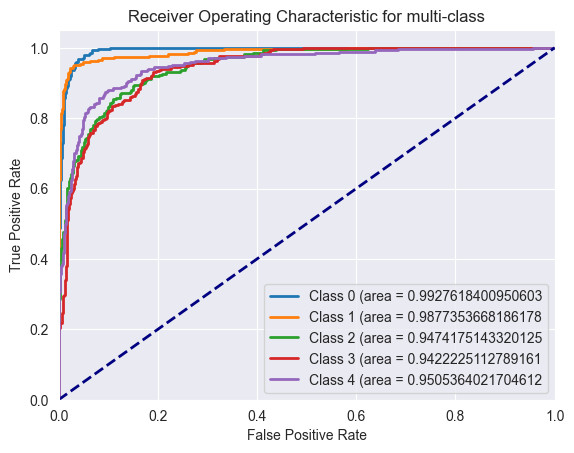

Overall ROC AUC: 0.9641347269390137


In [104]:
plot_roc_auc(model_da_es, test_generator)

21/21 [==============================] - 2s 107ms/step


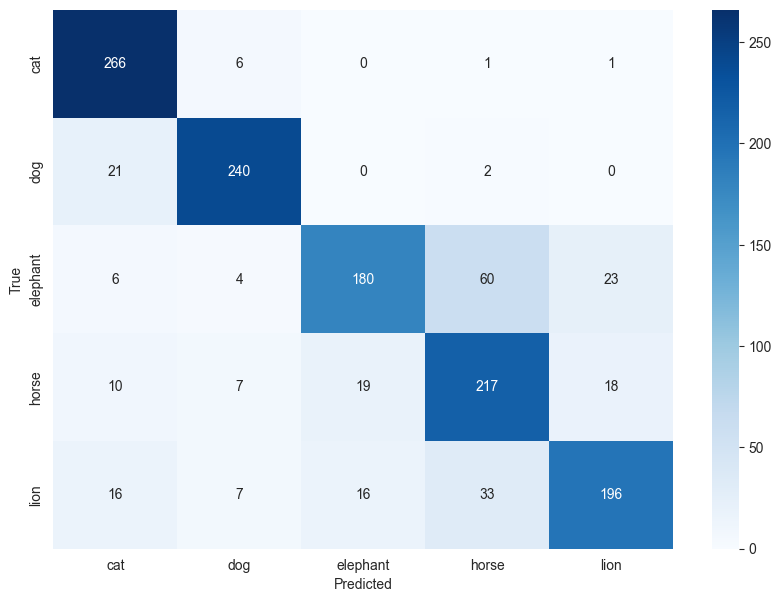

              precision    recall  f1-score   support

         cat       0.83      0.97      0.90       274
         dog       0.91      0.91      0.91       263
    elephant       0.84      0.66      0.74       273
       horse       0.69      0.80      0.74       271
        lion       0.82      0.73      0.77       268

    accuracy                           0.81      1349
   macro avg       0.82      0.81      0.81      1349
weighted avg       0.82      0.81      0.81      1349


In [105]:
plot_conf_matrix(model_da_es, test_generator)

In [107]:
# save the model
model_da_es.save('animals.keras')

# Using a pretrained convolutional Model


In [108]:
from keras.applications import VGG16

In [109]:
conv_base= VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

In [110]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [111]:
model_cbase_aug= models.Sequential()
model_cbase_aug.add(conv_base)
model_cbase_aug.add(layers.Flatten())
model_cbase_aug.add(layers.Dense(128, activation='relu'))
model_cbase_aug.add(layers.Dense(5, activation='softmax'))



In [112]:
model_cbase_aug.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 8192)              0         
                                                                 
 dense_14 (Dense)            (None, 128)               1048704   
                                                                 
 dense_15 (Dense)            (None, 5)                 645       
                                                                 
Total params: 15764037 (60.14 MB)
Trainable params: 15764037 (60.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [113]:
print(f'Number of trainable wieghts: {len(model_cbase_aug.trainable_weights)}')

Number of trainable wieghts: 30


In [114]:
conv_base.trainable = False

In [115]:
print(f'Number of trainable weights after freezing model base: {len(model_cbase_aug.trainable_weights)}')

Number of trainable weights after freezing model base: 4


In [116]:
steps_per_epoch= train_aug_generator.samples // train_aug_generator.batch_size
validation_steps= val_generator.samples // val_generator.batch_size

In [117]:
model_cbase_aug.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy']
)

In [118]:
history_model_cbase_aug = model_cbase_aug.fit(
    train_aug_generator,
    steps_per_epoch= steps_per_epoch,
    epochs= 10,
    validation_data= val_generator,
    validation_steps= validation_steps
)

Epoch 1/10
189/189 [==============================] - 282s 1s/step - loss: 0.5717 - accuracy: 0.7768 - val_loss: 0.3641 - val_accuracy: 0.8567
Epoch 2/10
189/189 [==============================] - 279s 1s/step - loss: 0.4363 - accuracy: 0.8279 - val_loss: 0.2786 - val_accuracy: 0.8920
Epoch 3/10
189/189 [==============================] - 280s 1s/step - loss: 0.3895 - accuracy: 0.8487 - val_loss: 0.2515 - val_accuracy: 0.9008
Epoch 4/10
189/189 [==============================] - 1259s 7s/step - loss: 0.3805 - accuracy: 0.8513 - val_loss: 0.2587 - val_accuracy: 0.9049
Epoch 5/10
189/189 [==============================] - 5711s 30s/step - loss: 0.3514 - accuracy: 0.8605 - val_loss: 0.2413 - val_accuracy: 0.9029
Epoch 6/10
189/189 [==============================] - 280s 1s/step - loss: 0.3419 - accuracy: 0.8680 - val_loss: 0.2463 - val_accuracy: 0.9008
Epoch 7/10
189/189 [==============================] - 277s 1s/step - loss: 0.3380 - accuracy: 0.8688 - val_loss: 0.2340 - val_accuracy: 0.9

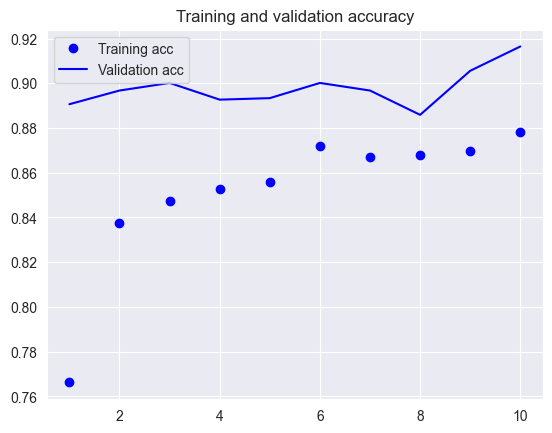

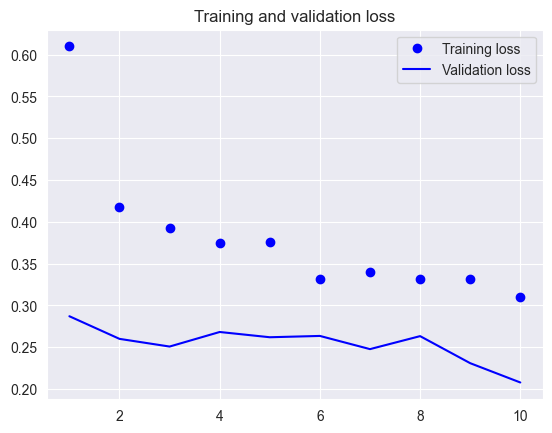

In [205]:
plot_acc_loss(history_model_cbase_aug)

22/22 [==============================] - 30s 1s/step


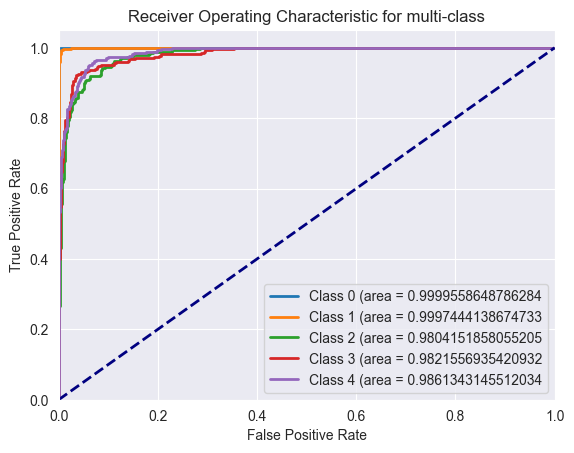

Overall ROC AUC: 0.9896810945289838


In [206]:
plot_roc_auc(model_cbase_aug, test_generator)

21/21 [==============================] - 28s 1s/step


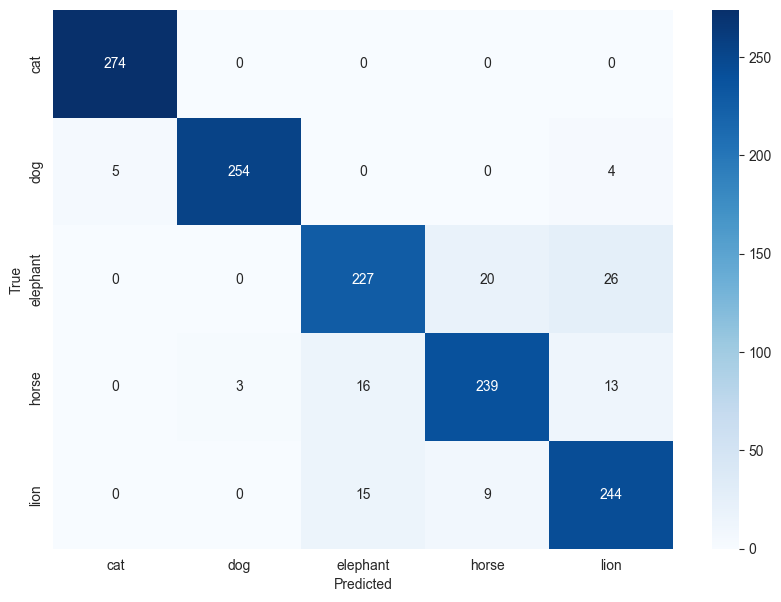

              precision    recall  f1-score   support

         cat       0.98      1.00      0.99       274
         dog       0.99      0.97      0.98       263
    elephant       0.88      0.83      0.85       273
       horse       0.89      0.88      0.89       271
        lion       0.85      0.91      0.88       268

    accuracy                           0.92      1349
   macro avg       0.92      0.92      0.92      1349
weighted avg       0.92      0.92      0.92      1349


In [209]:
plot_conf_matrix(model_cbase_aug, test_generator)

# References:

[1] Kaggle - Animals: Animals Classification Dataset; Url: https://www.kaggle.com/datasets/antobenedetti/animals/